In [1]:
import os
import time
import sys
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.backends import cudnn
from torch.nn import functional as F

from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

import load_so_data as so_data
import main as explor
import models
# import utils
import main

import importlib as imp
imp.reload(models)
# imp.reload(utils)
imp.reload(main)
imp.reload(so_data)
# Define data root directory

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Parameters
params = {'batch_size': 256, 'shuffle': True, 'num_workers': 6}
max_epochs = 25

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

window_len = 5*7

common_params = {
    'window_length': window_len,
    'badge_focus': 'Electorate',
    'out_dim': 'QuestionVotes',
    'data_path': '../data'
}

common_params['return_user_id'] = True
dset_train = so_data.StackOverflowDatasetIncCounts(dset_type='train', subsample=5000, 
                                             **common_params, self_initialise=True)
scalers = dset_train.get_scalers()
dset_test = so_data.StackOverflowDatasetIncCounts(dset_type='test', subsample=1500, 
                                             **common_params, scaler_in=scalers[0], scaler_out=scalers[1])
dset_valid = so_data.StackOverflowDatasetIncCounts(dset_type='validate', subsample=1500, centered=True,
                                             **common_params, scaler_in=scalers[0], scaler_out=scalers[1])

params = {'batch_size': 256, 'shuffle': True, 'num_workers': 6}
train_loader = DataLoader(dset_train, **params)
test_loader = DataLoader(dset_test, **params)
valid_loader = DataLoader(dset_valid, **params)

  4%|▍         | 156/4149 [00:00<00:02, 1556.04it/s]

Processing training data


100%|██████████| 4149/4149 [00:02<00:00, 1666.94it/s]


In [3]:
len(dset_train), len(dset_test), len(dset_valid)

(4149, 1381, 1386)

In [4]:
len(dset_train)+len(dset_test)+len(dset_valid)

6916

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

dset_shape = dset_train.__getitem__(0)[0].size()
params = {
    'device': device,
    'proximity_to_badge': True
}
dset_shape

torch.Size([70, 7])

In [6]:
# model_base = models.BaselineVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
# PATH = '../models/baseline_count.pt'
# model_base.load_state_dict(torch.load(PATH, map_location=device))
# model = model_base

In [7]:
def calc_elbo(dset_loader, model, loss_fn):
    model.eval()
    validation_loss = 0
    reconst_loss = 0
    for val_in, kernel_data, val_out, val_prox, badge_date, _ in dset_loader:
        # Transfer to GPU
        val_in, kernel_data, val_out, val_prox, badge_date = val_in.to(device), kernel_data.to(device), val_out.to(device), val_prox.to(device), badge_date.to(device)
        recon_batch, latent_loss = model(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)

        loss = loss_fn(recon_batch, val_out, latent_loss)
        validation_loss += loss.item()
        
        exp = (recon_batch[0]*recon_batch[1]).detach().numpy()
#         print(exp)
#         print((exp.detach()-val_out)**2)
        reconst_loss += np.mean((exp-val_out.detach().numpy())**2)

    print(-validation_loss/len(valid_loader.dataset))
    print(reconst_loss/len(valid_loader.dataset))

In [8]:
def plot_kernel(dset, model, dset_shape, device, ax=None, title="", ylim=[-20, 20]):
    
    val_in, kernel_data, val_out, val_prox, badge_date, _ = dset.__getitem__(0)

    val_in, kernel_data, val_out, val_prox, badge_date = val_in.reshape(-1,dset_shape[0],dset_shape[1]).to(device), \
                        kernel_data.reshape(-1,window_len*2).to(device), \
                        val_out.reshape(-1,window_len*2).to(device),     \
                        val_prox.reshape(-1,dset_shape[0]).to(device),    \
                        badge_date.reshape(-1,).to(device)
    
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize=(15,6)) 
        
    recon_batch, loss_params = model(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)
    mu = model.get_z(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)
    
    k = model.kernel(mu, val_in, kernel_data=kernel_data)
    for k_ in k:
        kern = k_.detach().numpy()
        kern[5*7-1] = kern[5*7-2]
        kern[5*7] = kern[5*7-2]
        ax.plot(np.arange(-5*7, 5*7), kern, lw=3, alpha=1, c='C1',
                label='$\\beta_1$ (Change in Activity Likelihood)')
    
    k = model.kernel_count(mu, val_in, kernel_data=kernel_data)
    for k_ in k:
        kern = k_.detach().numpy()
        kern[5*7-1] = kern[5*7-2]
        kern[5*7] = kern[5*7-2]
        ax.plot(np.arange(-5*7, 5*7), kern, lw=3, alpha=1, c='C0',
                label='$\\beta_2$ (Change in Expected Count)')

    ax.axvline(x=0, lw=2, ls='--', color='black')
    ax.axhline(y=0, lw=2, ls='--', color='black')
    ax.set_ylim(*ylim)
    title = model.__class__ if len(title)==0 else title
    ax.set_title(title, fontsize=15)
    
    ax.set_xticks(np.arange(-5*7, 6*7, 7))
    ax.set_xticklabels(np.arange(-5*7, 6*7, 7), fontsize=20)
    
    ax.set_xlabel('Days before/after badge', fontsize=22)
    ax.set_ylabel('Parameter value', fontsize=22)
    
    ax.legend(loc='best', fontsize=22)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
#     ax.tick_params(axis='both', which='minor', labelsize=8)

    return ax

In [9]:
def ZeroInflatedPoisson_loss_function(recon_x, x, latent_loss):
    from torch.distributions import Poisson

    x_shape = x.size()
    # if x == 0
    recon_x_0_bin = recon_x[0]
    recon_x_0_count = recon_x[1]

    poisson_0 = (x==0).float()*Poisson(recon_x_0_count).log_prob(x)
    # else if x > 0
    poisson_greater0 = (x>0).float()*Poisson(recon_x_0_count).log_prob(x)

    zero_inf = torch.cat((
        torch.log((1-recon_x_0_bin)+1e-9).view(x_shape[0], x_shape[1], -1),
        poisson_0.view(x_shape[0], x_shape[1], -1)
    ), dim=2)

    log_l = (x==0).float()*torch.logsumexp(zero_inf, dim=2)
    log_l += (x>0).float()*(torch.log(recon_x_0_bin+1e-9)+poisson_greater0)

    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return -(log_l.sum()) + latent_loss

# Plot the learnt kernels for each of the same models:

In [10]:
model_base = models.NormalizingFlowBaseline(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/baseline_flow_count.pt'
model_base.load_state_dict(torch.load(PATH, map_location=device))
model = model_base
loss = ZeroInflatedPoisson_loss_function
calc_elbo(test_loader, model, loss_fn=loss)

-115.76196817505411
0.1883334590587093


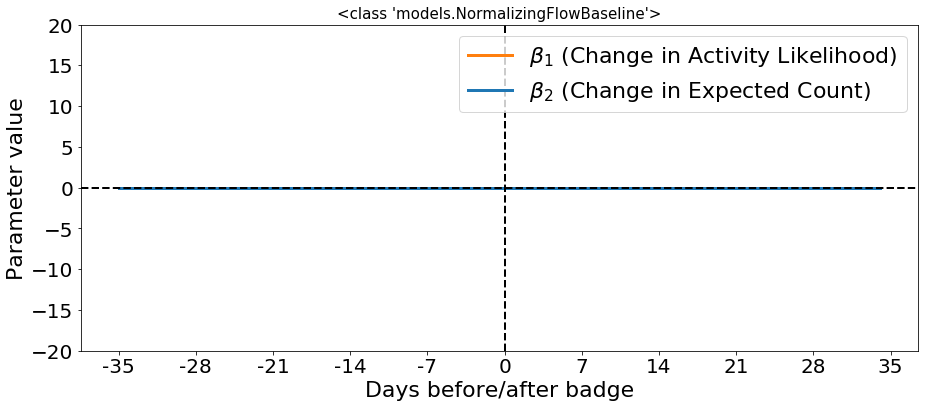

In [11]:
plot_kernel(dset_train, model, dset_shape, device)

In [12]:
# model_lin = models.LinearParametricVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
# PATH = '../models/linear_count.pt'
# model_lin.load_state_dict(torch.load(PATH, map_location=device))
# model = model_lin
# calc_elbo(test_loader, model, loss_fn=loss)

In [13]:
# plot_kernel(dset_train, model, dset_shape, device)

In [14]:
# model_pers_lin = models.LinearParametricPlusSteerParamVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
# PATH = '../models/personalised_linear_count.pt'
# model_pers_lin.load_state_dict(torch.load(PATH, map_location=device))
# model = model_pers_lin
# calc_elbo(test_loader, model, loss_fn=loss)

In [15]:
# plot_kernel(dset_train, model, dset_shape, device)

In [16]:
model_fp = models.NormalizingFlowFP(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/fp_flow_count.pt'
model_fp.load_state_dict(torch.load(PATH, map_location=device))
model = model_fp
calc_elbo(test_loader, model, loss_fn=loss)

-105.28423992999188
0.16689041682652064


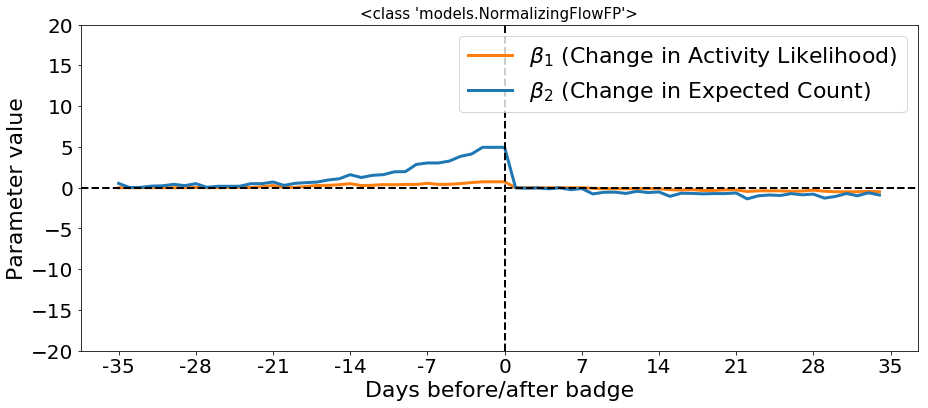

In [17]:
plot_kernel(dset_train, model, dset_shape, device, ylim=[-20,20])

In [18]:
# model_pers_fp = models.FullParameterisedPlusSteerParamVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
# PATH = '../models/full_personalised_parameterised_count.pt'
# model_pers_fp.load_state_dict(torch.load(PATH, map_location=device))
# model = model_pers_fp
# calc_elbo(test_loader, model, loss_fn=loss)

In [19]:
# plot_kernel(dset_train, model, dset_shape, device, ylim=[-20,20])

In [20]:
model_pers_fp = models.NormalizingFlowFP_PlusSteer(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/full_personalised_normalizing_flow.pt'
model_pers_fp.load_state_dict(torch.load(PATH, map_location=device))
model = model_pers_fp
calc_elbo(test_loader, model, loss_fn=loss)

-78.81302210159632
0.12553450899550753


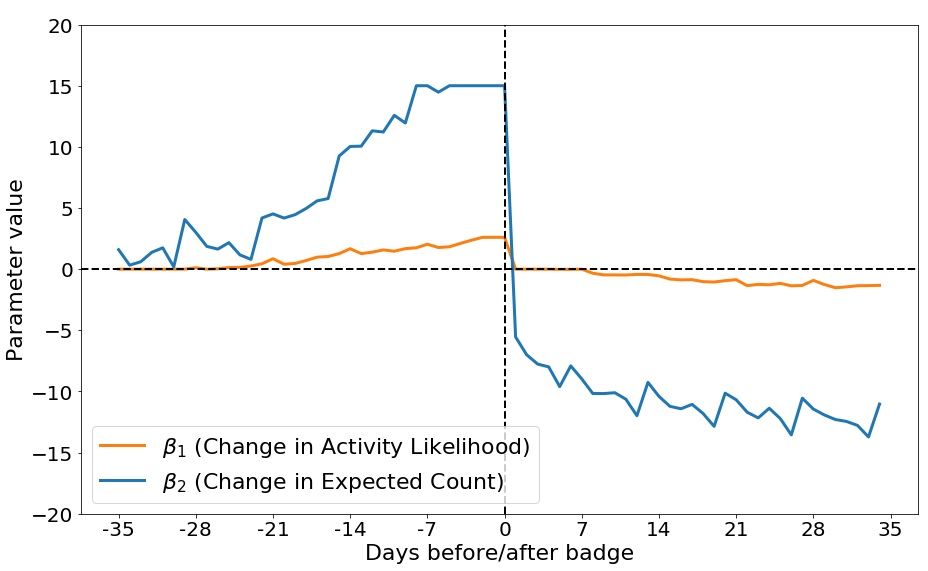

In [21]:
fig, ax = plt.subplots(1,1, figsize=(15,9)) 
plot_kernel(dset_train, model, dset_shape, device, ylim=[-20,20], title=' ', ax=ax)
fig.savefig('/Users/nickhoernle/Desktop/plot_of_beta.eps', format='eps', bbox_inches='tight')

In [22]:
import torch.distributions as distrib

latent_dim, latent_dim2 = [], []

p = 19

x_outs = []
recons = []
kern1 = []
kern2 = []
u_ids = []
x_ins = []
base_recon = []


for loader in [train_loader, test_loader, valid_loader]:
    for x_in, kernel, x_out, prox, badge_ix, u_id in loader:
        x_in, kernel, x_out, prox, badge_ix = x_in.to(device),\
                                                kernel.to(device),\
                                                x_out.to(device),\
                                                prox.to(device),\
                                                badge_ix.to(device)

        recon_batch, loss_params = model(x_in, kernel_data=kernel, dob=badge_ix, prox_to_badge=prox)
    #     zparams = model.encode(x_in.view(-1, model.obs_dim), 
    #                                           kernel_data=kernel, 
    #                                           dob=badge_ix, 
    #                                           prox_to_badge=prox)
        recon_base, _ = model_base(x_in, kernel_data=kernel, dob=badge_ix, prox_to_badge=prox)

        cur_z = np.mean([model.get_z(x_in, kernel_data=kernel, dob=badge_ix, prox_to_badge=prox).detach().numpy() for i in range(100)], axis=0)
    #     cur_z, _ = model.latent_loss(x_in.view(-1, model.obs_dim), (cur_mu,cur_sig))
    #     print(cur_mu.shape)
    #     model

    #     break
    #     cur_z, _ = model.latent_loss(x_in.view(-1, model.obs_dim), (cur_mu,cur_sig) )

        kernelz1 = model.kernel(cur_z, x_in, kernel_data=kernel)
        kernelz2 = model.kernel_count(cur_z, x_in, kernel_data=kernel)
        
        x_in_shape = x_in.size()
        x_in = dset_train.inverse_transform_in(x_in.view(-1,x_in_shape[1]*x_in_shape[2])).reshape(-1,x_in_shape[1],x_in_shape[2])
        
        for i in range(len(x_out)):
            x_outs += [x_out[i].detach().numpy()]
            x_ins += [x_in[i,:,:].detach().numpy()]
            recons += [(recon_batch[0][i]*recon_batch[1][i]).detach().numpy()]
            kern1 += [kernelz1[i].detach().numpy()]
            kern2 += [kernelz2[i].detach().numpy()]
            latent_dim += [float(cur_z[i, -1])]
            latent_dim2 += [float(cur_z[i, -2])]
            u_ids += [u_id[i]]
            base_recon += [(recon_base[0][i]*recon_base[1][i]).detach().numpy()]

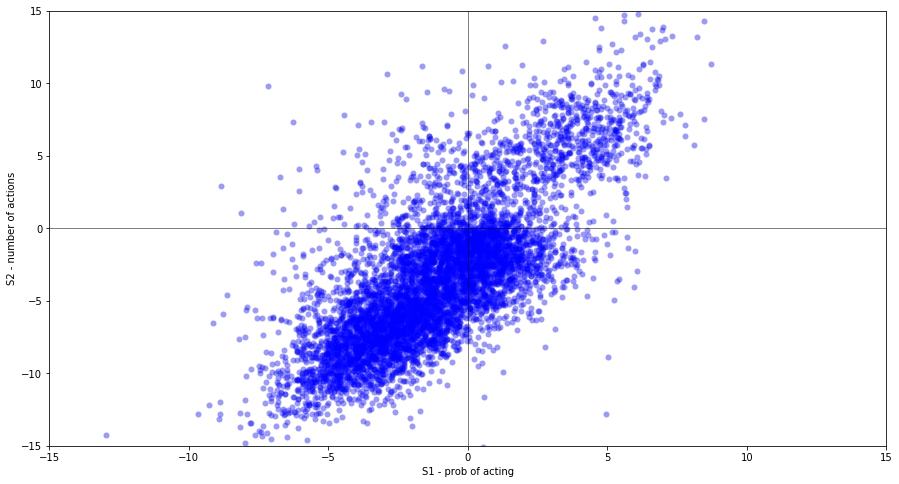

In [23]:
w1 = model.steer_weight[0].detach().numpy()
w2 = model.steer_weight[1].detach().numpy()

plt.figure(figsize=(15,8))
# plt.hexbin(w1*np.array(latent_dim), w2*np.array(latent_dim2), cmap='rainbow')
plt.scatter(w1*np.array(latent_dim), w2*np.array(latent_dim2), alpha=.4, color='blue', lw=0)

plt.xlabel('S1 - prob of acting')
plt.ylabel('S2 - number of actions')

plt.axvline(0, c='black', lw=.5)
plt.axhline(0, c='black', lw=.5)

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.show()

In [24]:
sigmoid = lambda x: np.exp(x)/(1+np.exp(x))

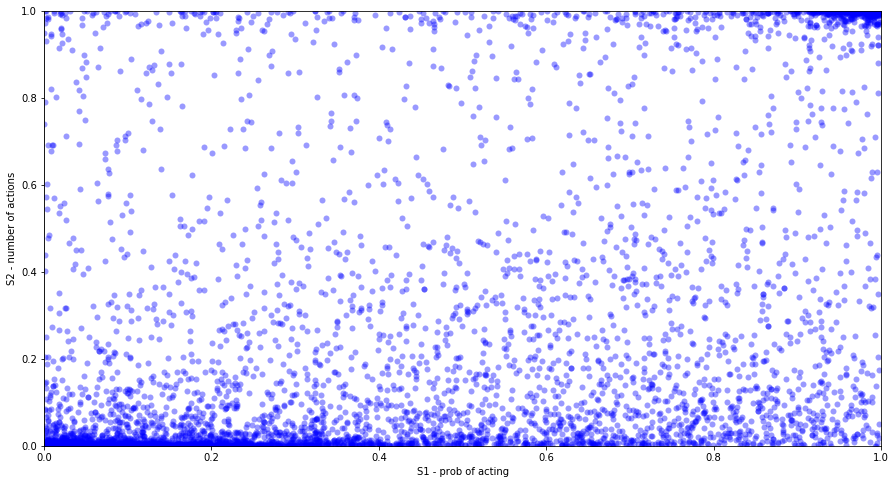

In [25]:
w1 = model.steer_weight[0].detach().numpy()
w2 = model.steer_weight[1].detach().numpy()

plt.figure(figsize=(15,8))
# plt.hexbin(w1*np.array(latent_dim), w2*np.array(latent_dim2), cmap='rainbow')
plt.scatter(sigmoid(w1*np.array(latent_dim)), sigmoid(w2*np.array(latent_dim2)), alpha=.4, color='blue', lw=0)

plt.xlabel('S1 - prob of acting')
plt.ylabel('S2 - number of actions')

plt.axvline(0, c='black', lw=.5)
plt.axhline(0, c='black', lw=.5)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [33]:
w1_thresh_pos=.3
w2_thresh_pos=.3

w1_thresh_neg=.2
w2_thresh_neg=.1

s1_s2 =         (sigmoid(w1*latent_dim) >= w1_thresh_pos)     & (sigmoid(w2*latent_dim2) >= w2_thresh_pos)# | center
min_s1_min_s2 = (sigmoid(w1*latent_dim) <= w1_thresh_neg) & (sigmoid(w2*latent_dim2) <= w2_thresh_neg)# & ~center
center =        ~(s1_s2 | min_s1_min_s2)

print('Top Right', np.sum(s1_s2), '&', round(100*np.sum(s1_s2)/len(s1_s2),2),'%')
print('Bottom Left', np.sum(min_s1_min_s2),'&',round(100* np.sum(min_s1_min_s2)/len(s1_s2),2),'%')
print('Center', np.sum(center),'&', round(100*np.sum(center)/len(s1_s2),2),'%')

Top Right 1457 & 21.07 %
Bottom Left 2899 & 41.92 %
Center 2560 & 37.02 %


In [27]:
thresh_s1 = -1
thresh_s2 = -1

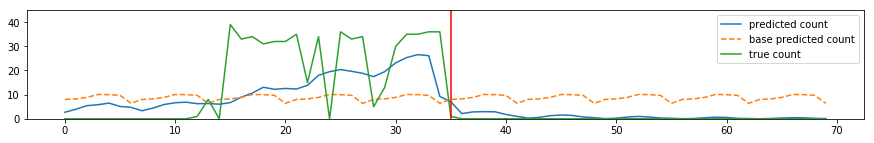

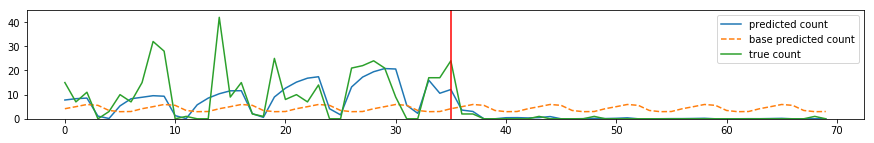

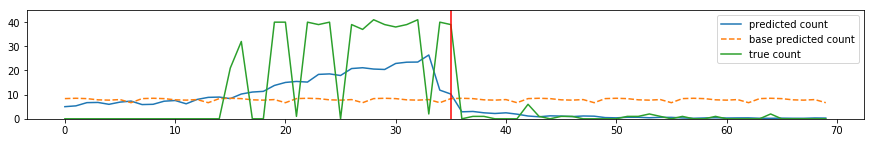

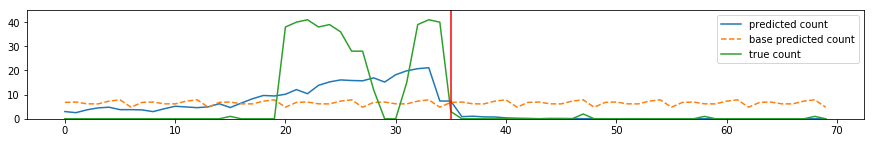

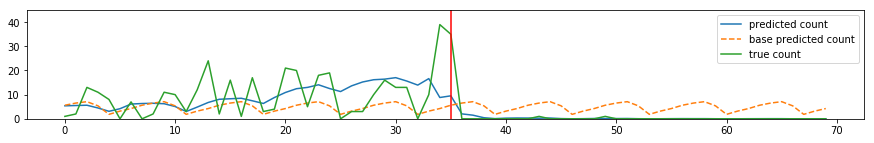

In [28]:
i = 0
top_right, top_left, bottom_right, bottom_left = [], [], [], []
top_left_s, top_right_s, bottom_right_s, bottom_left_s = [], [], [], []

to_plot = list(range(len(latent_dim)))
to_plot = np.random.choice(to_plot, size=len(to_plot), replace=False)

for j in to_plot:
    if (s1_s2[j] == 1):
        
        if i > 4:
            continue
            
        top_right_s.append(1)
        top_right.append((recons[j], x_outs[j]))
        
        plt.figure(figsize=(15,2))
        plt.plot(recons[j], label='predicted count')
        plt.plot(base_recon[j], ls='--', label='base predicted count')
        
        # plt.plot(kern1[j], c='black', ls='--', alpha=.5)
        # plt.plot(kern2[j], c='green', ls='--', alpha=.5)
        plt.plot(x_outs[j], label='true count')
        plt.axvline(5*7, c='red')
        plt.ylim([0,45])
        plt.legend(loc='best')
        plt.show()
        
        i += 1
    else:
        top_right_s.append(0)

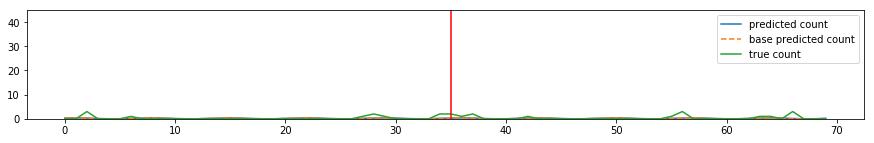

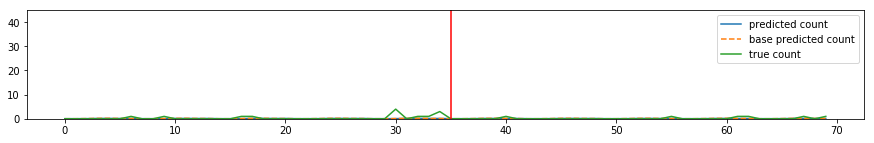

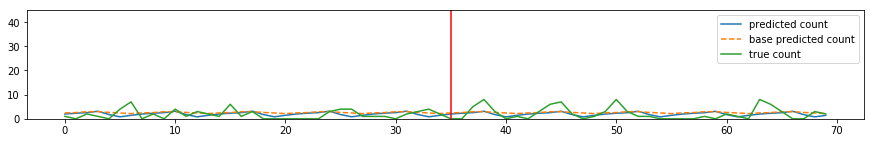

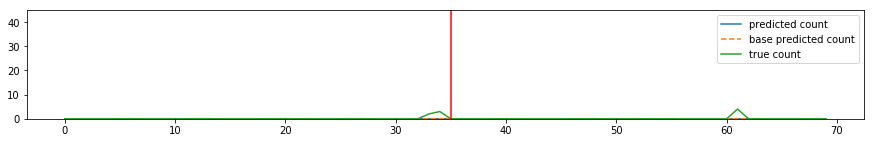

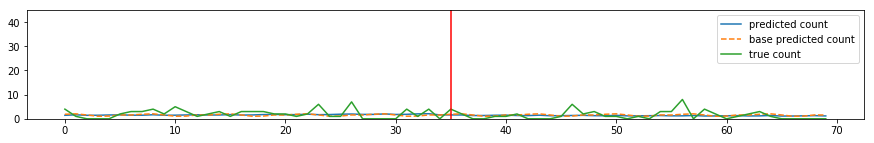

In [29]:
i = 0
bottom_left = []
to_plot = list(range(len(latent_dim)))
to_plot = np.random.choice(to_plot, size=len(to_plot), replace=False)
for j in to_plot:
    if (min_s1_min_s2[j] == 1):
        
        bottom_left.append((recons[j], x_outs[j]))
        
        plt.figure(figsize=(15,2))
        plt.plot(recons[j], label='predicted count')
        plt.plot(base_recon[j], ls='--', label='base predicted count')

        # plt.plot(kern1[j], c='black', ls='--', alpha=.5)
        # plt.plot(kern2[j], c='green', ls='--', alpha=.5)
        plt.plot(x_outs[j], label='true count')
        plt.axvline(5*7, c='red')
        plt.ylim([0,45])
        plt.legend(loc='best')
        plt.show()
        
        i += 1
        
        if i > 4:
            break

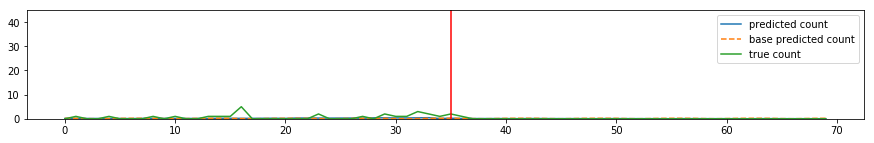

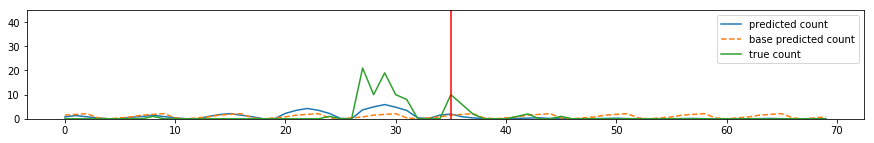

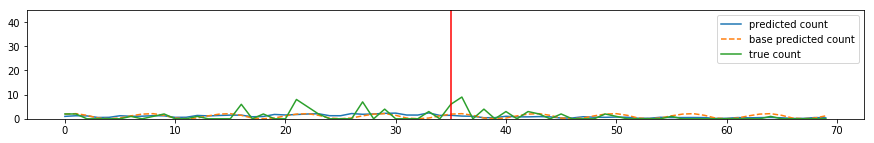

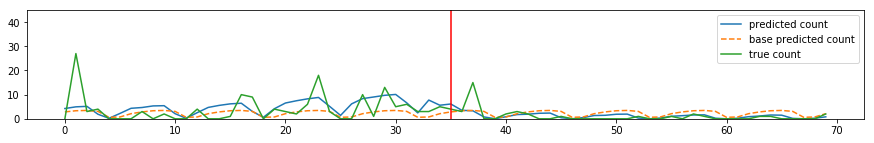

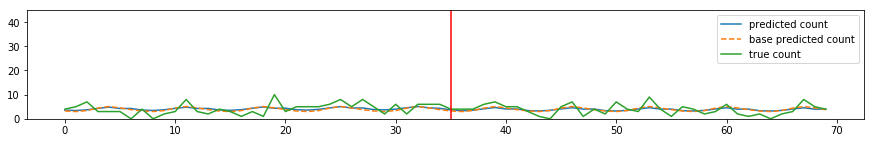

In [30]:
i = 0
for j in range(len(latent_dim)):
    if (center[j] == 1):
        
        top_left.append((recons[j], x_outs[j]))
        
        plt.figure(figsize=(15,2))
        plt.plot(recons[j], label='predicted count')
        plt.plot(base_recon[j], ls='--', label='base predicted count')

        # plt.plot(kern1[j], c='black', ls='--', alpha=.5)
        # plt.plot(kern2[j], c='green', ls='--', alpha=.5)
        plt.plot(x_outs[j], label='true count')
        plt.axvline(5*7, c='red')
        plt.ylim([0,45])
        plt.legend(loc='best')
        plt.show()
        
        i += 1
        
        if i > 4:
            break

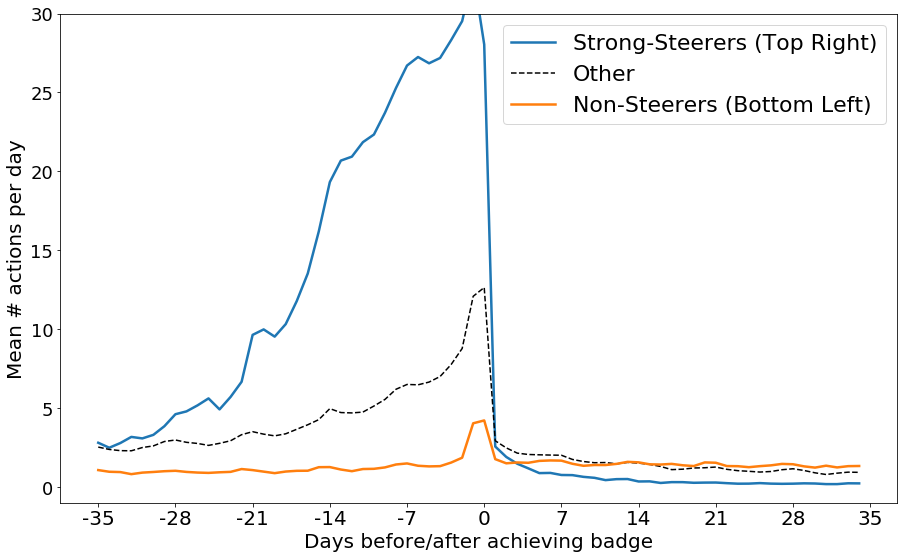

In [31]:
# print('center', np.sum(center))
# print('min-S1 min-S2', np.sum(min_s1_min_s2))
x_outs = np.array(x_outs)

plt.figure(figsize=(15,9))
plt.plot(np.mean(x_outs[s1_s2], axis=0), label='Strong-Steerers (Top Right)', lw=2.5, color='C0')
plt.plot(np.mean(x_outs[center], axis=0), label='Other', ls='--',  lw=1.5, color='black')
plt.plot(np.mean(x_outs[min_s1_min_s2], axis=0), label='Non-Steerers (Bottom Left)',   lw=2.5, color='C1')
# plt.plot(np.mean(x_outs[min_s1_min_s2], axis=0), label='Bottom Left - Not Steered',   lw=2, color='red')
# plt.plot(np.mean(x_outs[center], axis=0), label='Bottom Left - Not Steered')

plt.xticks(np.arange(0, 11*7, 7), np.arange(-5*7, 6*7, 7), fontsize=20)
plt.yticks(fontsize=18)
plt.xlabel('Days before/after achieving badge', fontsize=20)
plt.ylabel('Mean # actions per day', fontsize=20)

plt.legend(loc='best', fontsize=22)
plt.ylim([-1,30])
fig = plt.gcf()
fig.savefig('/Users/nickhoernle/Desktop/steering_mean_response.eps', format='eps', bbox_inches='tight')
# plt.plot(np.mean(x_outs[(w1*latent_dim < -.25) & (w2*latent_dim2 < -.25)], axis=0))
plt.show()

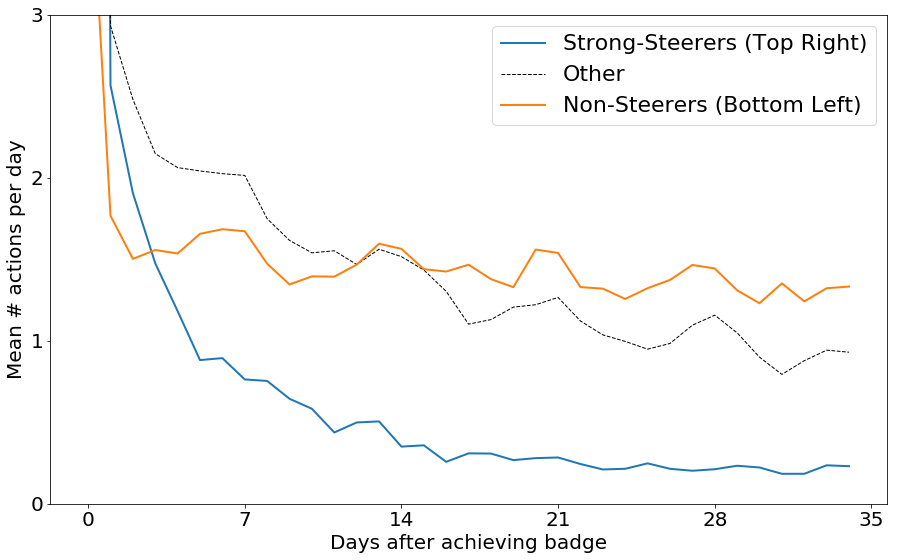

In [32]:
x_outs = np.array(x_outs)

plt.figure(figsize=(15,9))
plt.plot(np.mean(x_outs[s1_s2, 5*7:], axis=0),         label='Strong-Steerers (Top Right)', lw=2, color='C0')
plt.plot(np.mean(x_outs[center, 5*7:], axis=0), label='Other', ls='--',  lw=1, color='black')
plt.plot(np.mean(x_outs[min_s1_min_s2, 5*7:], axis=0),        label='Non-Steerers (Bottom Left)',   lw=2, color='C1')
# plt.plot(np.mean(x_outs[min_s1_min_s2], axis=0), label='Bottom Left - Not Steered',   lw=2, color='red')
# plt.plot(np.mean(x_outs[center], axis=0), label='Bottom Left - Not Steered')

plt.xticks(np.arange(0, 6*7, 7), np.arange(0*7, 6*7, 7), fontsize=20)
plt.yticks([0,1,2,3], [0,1,2,3], fontsize=20)
plt.xlabel('Days after achieving badge', fontsize=20)
plt.ylabel('Mean # actions per day', fontsize=20)

plt.legend(loc='best', fontsize=22)
plt.ylim([0,3])

fig = plt.gcf()
fig.savefig('/Users/nickhoernle/Desktop/steering_mean_response_after_badge.eps', format='eps', bbox_inches='tight')
# plt.plot(np.mean(x_outs[(w1*latent_dim < -.25) & (w2*latent_dim2 < -.25)], axis=0))
plt.show()

In [61]:
import scipy.stats as stats
import seaborn as sns

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Red line - no steering')

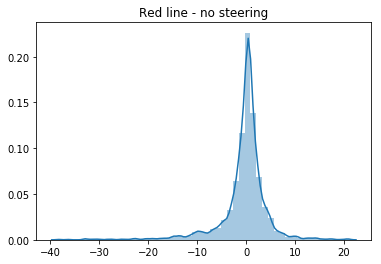

In [62]:
mask = x_outs[:,5*7-1]>0

count_on_day_0 = x_outs[(min_s1_min_s2&mask),5*7-1]
# vals = np.concatenate([x_outs[min_s1_min_s2&mask,:5*7-1], x_outs[min_s1_min_s2&mask,5*7:]], axis=1)

vals = x_outs[(min_s1_min_s2&mask)]

vals[:,5*7-1] = np.concatenate([vals[:,:5*7-1], vals[:,5*7:]], axis=1).mean(axis=1)

means = np.mean(vals, axis=1)
# means = np.array([np.mean(v[v>=1]) for v in vals])
# variances = np.array([np.std(v[v>=1])**2 for v in vals])
variances = np.std(vals, axis=1, ddof=0)**2

mask2 = ~((np.isnan(means)|(means==0)))

variances = variances[mask2]
count_on_day_0 = count_on_day_0[mask2]
means = means[mask2]

# plt.hist((means + variances/means)-count_on_day_0[count_on_day_0>0], bins=np.arange(-10.5,10.5,1), density=True)
# plt.plot(np.arange(-10,10), stats.norm(0,2.5).pdf(np.arange(-10,10)))
sns.distplot((means + variances/means)-count_on_day_0, color='C0')

plt.title('Red line - no steering')

In [63]:
def calc_mean(u):
    if np.isnan(np.mean(u[u>=1])):
        return 0
    return np.mean(u[u>=1])

def calc_exp2(u):
    if np.isnan(np.mean(u[u>=1])):
        return 0
    return np.mean(u[u>=1]**2)

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


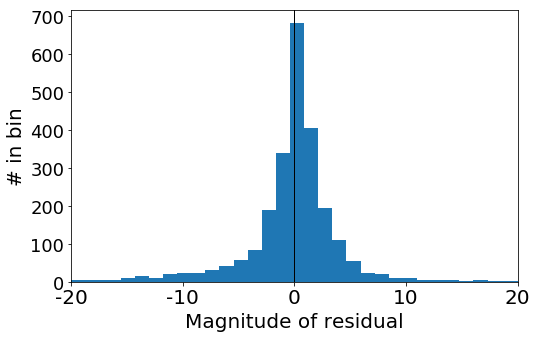

In [64]:
count_on_day_0 = x_outs[(min_s1_min_s2&mask),5*7-1]
means2 = np.sum(np.array([[calc_mean(u) for u in vals[:,np.arange(i,vals.shape[1],7)]] for i in range(0,7)]), axis=0)
exp_m_2 = np.sum(np.array([[calc_exp2(u) for u in vals[:,np.arange(i,vals.shape[1],7)]] for i in range(0,7)]), axis=0)

mask2 = ~((np.isnan(means2)|(means2==0)))
exp_m_2 = exp_m_2[mask2]
count_on_day_0 = count_on_day_0[mask2]
means2 = means2[mask2]

plt.figure(figsize=(8,5))
# sns.distplot((exp_m_2/means2)-count_on_day_0, color='C0', kde=False)
plt.hist((exp_m_2/means2)-count_on_day_0, color='C0', bins=50)
plt.axvline(0,c='black',lw=1)
plt.xlim([-20,20])
plt.ylabel('# in bin', fontsize=20)
plt.xlabel('Magnitude of residual', fontsize=20)
plt.xticks([-20,-10,0,10,20], [-20,-10,0,10,20], fontsize=20)
plt.yticks(fontsize=18)

fig = plt.gcf()
fig.savefig('/Users/nickhoernle/Desktop/hist1.eps', format='eps', bbox_inches='tight')

plt.show()

In [65]:
np.corrcoef(means2, exp_m_2)

array([[1.        , 0.91685065],
       [0.91685065, 1.        ]])

(0, 150)

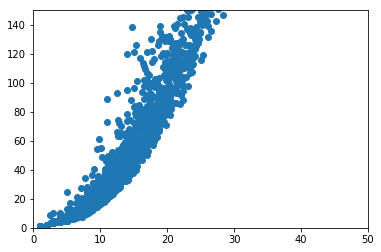

In [66]:
plt.scatter(means2, exp_m_2, alpha=1)
plt.xlim([0,50])
plt.ylim([0,150])

In [67]:
np.concatenate([vals[:,:5*7-1], vals[:,5*7:]], axis=1).mean(axis=1)

array([0.8115942, 1.6086956, 1.0434783, ..., 1.5797101, 2.115942 ,
       3.7536232], dtype=float32)

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Black dotted line - those in the middle')

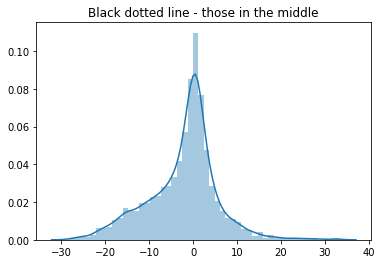

In [68]:
count_on_day_0 = x_outs[center&mask,5*7-1]
# vals = np.concatenate([x_outs[center&mask,:5*7-1], x_outs[center&mask,5*7:]], axis=1)

vals = x_outs[center&mask]
# vals[:,5*7-1] = np.concatenate([vals[:,:5*7-1], vals[:,5*7:]], axis=1).mean(axis=1)

means = np.mean(vals, axis=1)
variances = np.std(vals, axis=1, ddof=0)**2

variances = variances[means>0]
count_on_day_0 = count_on_day_0[means>0]
means = means[means>0]


# plt.hist((means + variances/means)-count_on_day_0[count_on_day_0>0], bins=np.arange(-10.5,10.5,1), density=True)
# plt.plot(np.arange(-10,10), stats.norm(0,2.5).pdf(np.arange(-10,10)))
sns.distplot((means + variances/means)-count_on_day_0, color='C0')
plt.title('Black dotted line - those in the middle')

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


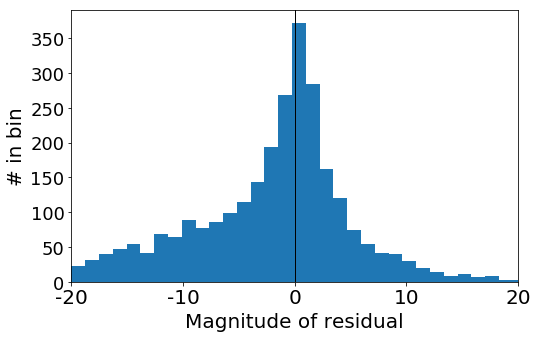

In [69]:
count_on_day_0 = x_outs[center&mask,5*7-1]

means2 = np.sum(np.array([[calc_mean(u) for u in vals[:,np.arange(i,vals.shape[1],7)]] for i in range(0,7)]), axis=0)
exp_m_2 = np.sum(np.array([[calc_exp2(u) for u in vals[:,np.arange(i,vals.shape[1],7)]] for i in range(0,7)]), axis=0)

plt.figure(figsize=(8,5))
# sns.distplot((exp_m_2/means2)-count_on_day_0, color='C0', kde=False)
plt.hist((exp_m_2/means2)-count_on_day_0, color='C0', bins=50)
plt.axvline(0,c='black',lw=1)
plt.xlim([-20,20])
plt.ylabel('# in bin', fontsize=20)
plt.xlabel('Magnitude of residual', fontsize=20)
plt.xticks([-20,-10,0,10,20], [-20,-10,0,10,20], fontsize=20)
plt.yticks(fontsize=18)
plt.show()

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Blue line - strong steering')

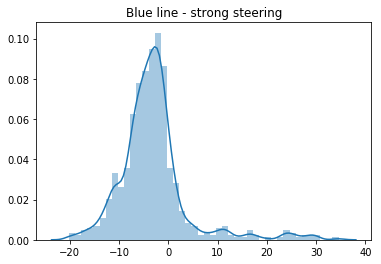

In [70]:
count_on_day_0 = x_outs[s1_s2&mask][:,5*7-1]
# vals = np.concatenate([x_outs[s1_s2&mask,:5*7-1], x_outs[s1_s2&mask,5*7:]], axis=1)
vals = x_outs[s1_s2&mask]

means = np.mean(vals, axis=1)
variances = np.std(vals, axis=1, ddof=0)**2
variances = variances[means>0]


# plt.hist((means + variances/means)-count_on_day_0[count_on_day_0>0], bins=np.arange(-10.5,10.5,1), density=True)
# plt.plot(np.arange(-10,10), stats.norm(0,2.5).pdf(np.arange(-10,10)))
sns.distplot((means[means>0] + variances/means[means>0])-count_on_day_0[count_on_day_0>0][means>0])
plt.title('Blue line - strong steering')

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


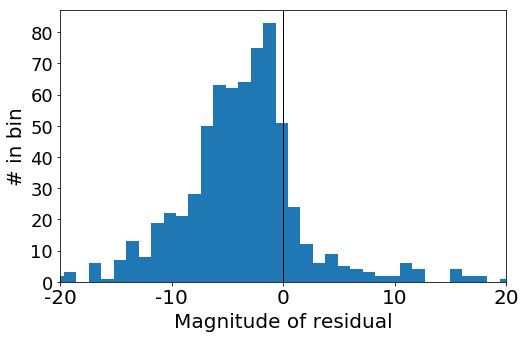

In [71]:
means2 = np.sum(np.array([[calc_mean(u) for u in vals[:,np.arange(i,vals.shape[1],7)]] for i in range(0,7)]), axis=0)
exp_m_2 = np.sum(np.array([[calc_exp2(u) for u in vals[:,np.arange(i,vals.shape[1],7)]] for i in range(0,7)]), axis=0)

plt.figure(figsize=(8,5))
# sns.distplot((exp_m_2/means2)-count_on_day_0, color='C0', kde=False)
plt.hist((exp_m_2/means2)-count_on_day_0, color='C0', bins=50)
plt.axvline(0,c='black',lw=1)
plt.xlim([-20,20])
plt.ylabel('# in bin', fontsize=20)
plt.xlabel('Magnitude of residual', fontsize=20)
plt.xticks([-20,-10,0,10,20], [-20,-10,0,10,20], fontsize=20)
plt.yticks(fontsize=18)

fig = plt.gcf()
fig.savefig('/Users/nickhoernle/Desktop/hist3.eps', format='eps', bbox_inches='tight')

plt.show()

In [72]:
x_ins = np.array(x_ins)
x_ins.shape

(6916, 70, 7)

In [73]:
x_ins.shape

(6916, 70, 7)

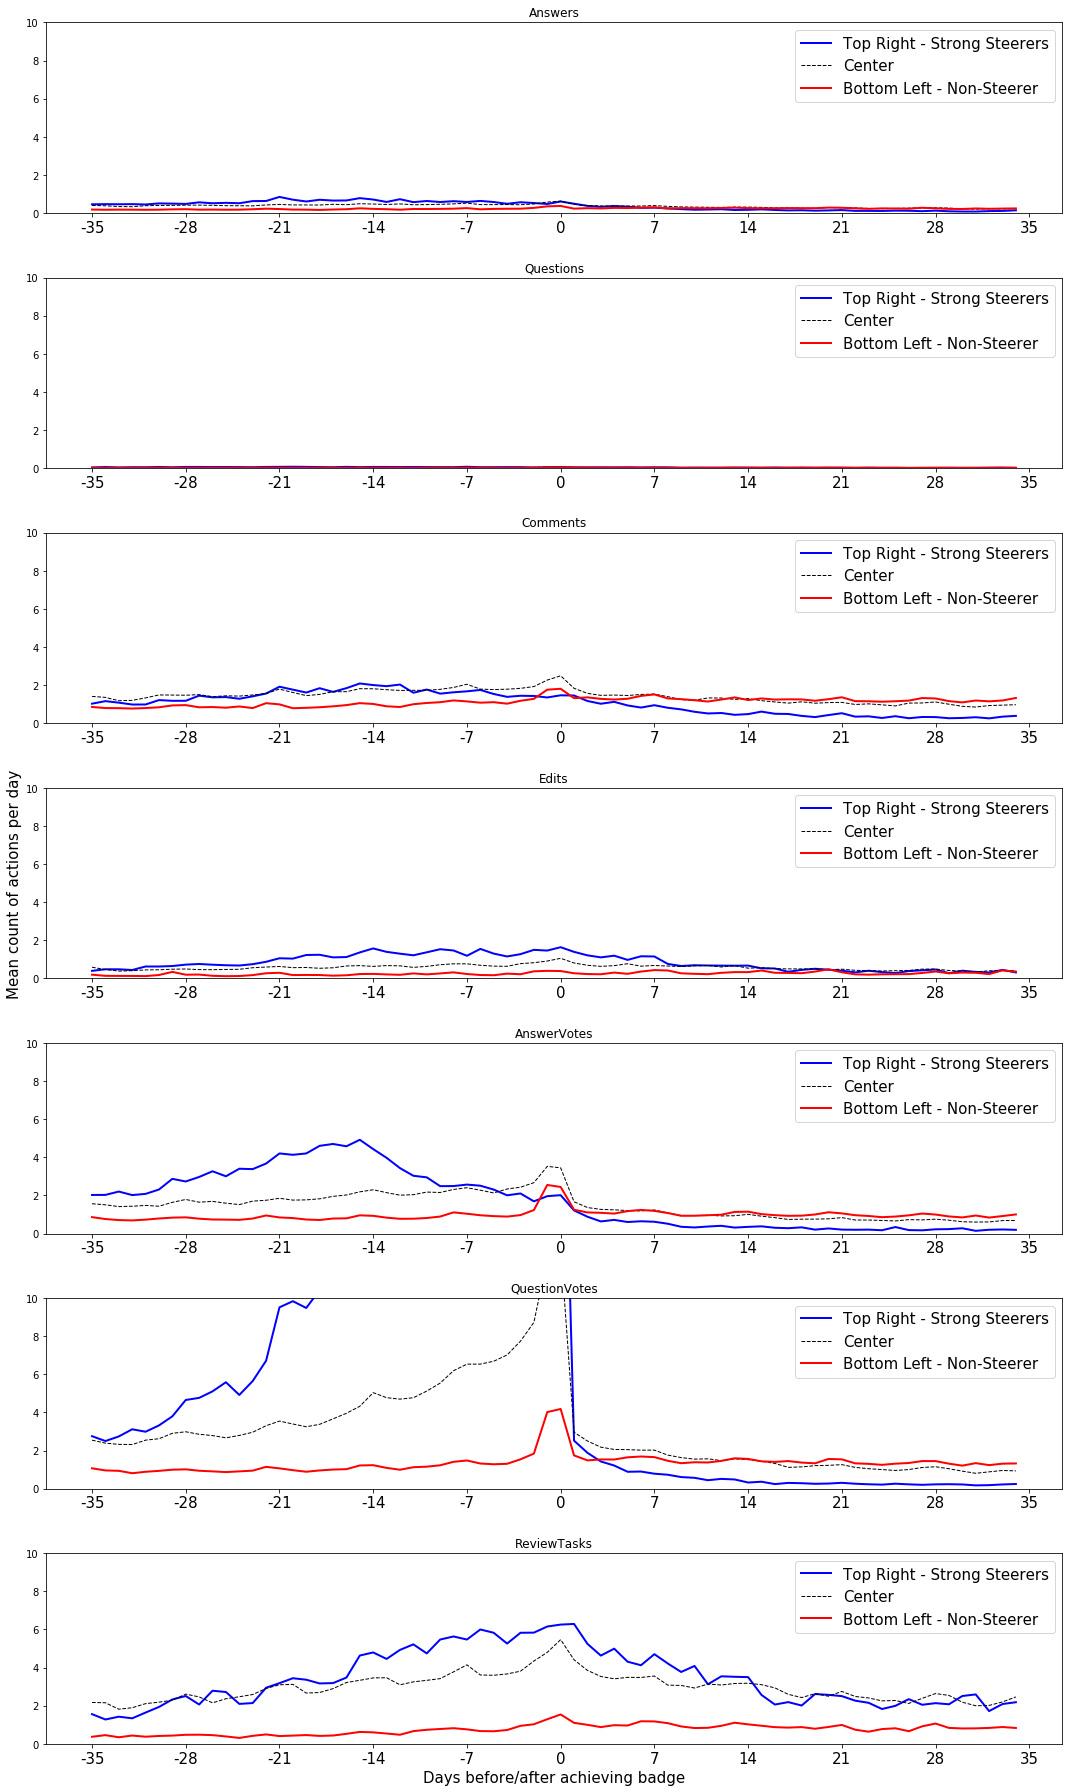

In [74]:
fig, axes = plt.subplots(7,1, figsize=(15,25))
for i, a in enumerate(so_data.ACTIONS):
#     axes[i].figure(figsize=(15,6))
    axes[i].set_title(a)
    
    axes[i].plot(np.mean(x_ins[s1_s2,:,i], axis=0),         label='Top Right - Strong Steerers', lw=2, color='blue')
    axes[i].plot(np.mean(x_ins[center,:,i], axis=0), label='Center', ls='--',  lw=1, color='black')
    axes[i].plot(np.mean(x_ins[min_s1_min_s2,:,i], axis=0),        label='Bottom Left - Non-Steerer',   lw=2, color='red')
    # plt.plot(np.mean(x_outs[center], axis=0), label='Bottom Left - Not Steered')

    axes[i].set_xticks(np.arange(0, 11*7, 7))
    axes[i].set_xticklabels(np.arange(-5*7, 6*7, 7), fontsize=15)
#     axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=15)
    if i == 3:
        axes[i].set_ylabel('Mean count of actions per day', fontsize=15)
    if i == 6:
        axes[i].set_xlabel('Days before/after achieving badge', fontsize=15)


    axes[i].legend(loc='best', fontsize=15)
    axes[i].set_ylim([0,10])
    # plt.plot(np.mean(x_outs[(w1*latent_dim < -.25) & (w2*latent_dim2 < -.25)], axis=0))
fig.tight_layout()
plt.show()

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


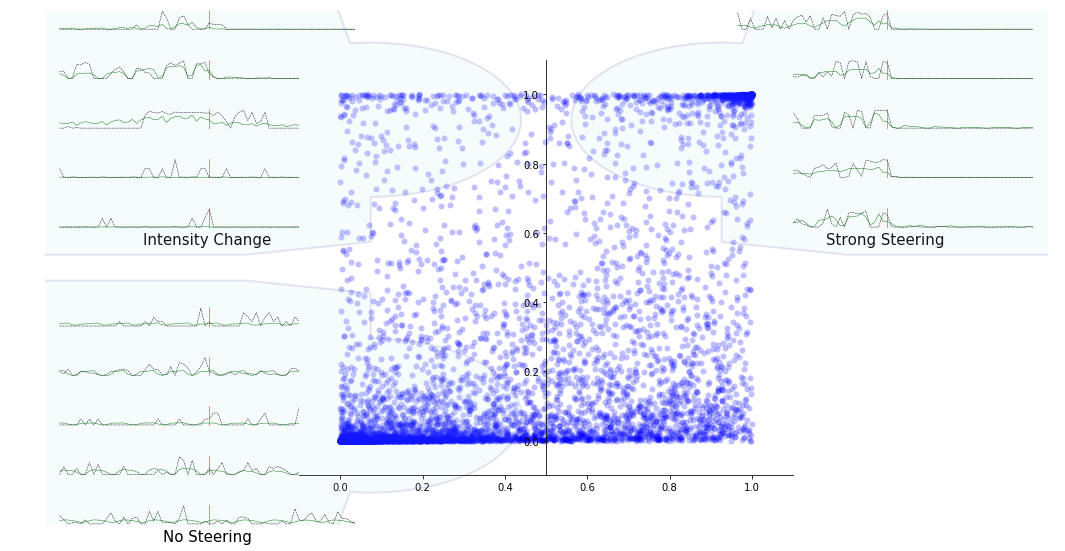

In [75]:
import matplotlib
# from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from descartes import PolygonPatch
import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.ops import cascaded_union

fig3 = plt.figure(figsize=(15,8), constrained_layout=True)

t1, t2, t3, t4, t5, t6 = .35,.1,.65,.6,.05,2


def get_polygons():
    offset = .2
    p = [
        Polygon([[ t1,  t2],[ t1,  t3],[ t4,  t6],[ t6,  t6],[ t6, t5],[ t4, t5]]),
        Polygon([[-t1, -t2],[-t1, -t3],[-t4, -t6],[-t6, -t6],[-t6,-t5],[-t4,-t5]]),
#         Polygon([[ t1, -t2],[ t1, -t3],[ t4, -t6],[ t6, -t6],[ t6,-t5],[ t4,-t5]]),
        Polygon([[-t1,  t2],[-t1,  t3],[-t4,  t6],[-t6,  t6],[-t6, t5],[-t4, t5]])
    ] + [
        Point((t1), t3-(t3-t2)/2+offset).buffer(.3),
        Point((-t1), t3-(t3-t2)/2+offset).buffer(.3),
#         Point((t1), -(t3-(t3-t2)/2)).buffer(.3),
        Point(-(t1), -(t3-(t3-t2)/2)-offset).buffer(.3)
    ]
    return cascaded_union(p)

def plot_line(ax, arrays):
    ax.plot(arrays[0], c='green', lw=.5)
    ax.plot(arrays[1], c='black', ls='--', lw=.5)
    ax.axvline(5*7, c='red', lw=.5)
#     ax.set_ylim([-1,40])
    return ax

gs = fig3.add_gridspec(11, 12)

top_left_axes = []
for i in range(5):
    ax = fig3.add_subplot(gs[i, :4])
    plot_line(ax, top_left[i])
    top_left_axes.append(ax)
    
bottom_left_axes = []
for i in range(5):
    ax = fig3.add_subplot(gs[6+i, :4])
    plot_line(ax, bottom_left[i])
    bottom_left_axes.append(ax)
    
top_right_axes = []
for i in range(5):
    ax = fig3.add_subplot(gs[i, -4:])
    plot_line(ax, top_right[i])
    top_right_axes.append(ax)
    
# bottom_right_axes = []
# for i in range(5):
#     ax = fig3.add_subplot(gs[6+i, -4:])
#     plot_line(ax, bottom_right[i])
#     bottom_right_axes.append(ax)
    
center_ax = fig3.add_subplot(gs[1:-1, 3:-3])

sigmoid = lambda x: np.exp(x)/(1+ np.exp(x))

center_ax.scatter(sigmoid(w1*np.array(latent_dim)), 
                  sigmoid(w2*np.array(latent_dim2)), alpha=.25, color='blue', lw=0)
# center_ax.axvline(0, ymin=0.05, ymax=.95, c='black')
# center_ax.axhline(0, xmin=0.05, xmax=.95, c='black')
center_ax.set_xlim([-.1,1.1])
center_ax.set_ylim([-.1,1.1])

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
center_ax.spines['left'].set_position('center')
# center_ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
center_ax.spines['right'].set_color('none')
center_ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
# center_ax.xaxis.set_ticks_position('bottom')
center_ax.yaxis.set_ticks_position('left')

tot_ax = fig3.add_subplot(gs[:,:])
tot_ax.set_axis_off()
patch2b = PolygonPatch(get_polygons(), fc='lightblue', ec='darkblue', lw=2, alpha=.1, zorder=2)
tot_ax.add_patch(patch2b)
# tot_ax.add_patch(patch3b)
tot_ax.set_xlim([-1,1])
tot_ax.set_ylim([-1,1])

all_ax = top_left_axes + bottom_left_axes + top_right_axes
# all_ax = [center_ax]

for ax in all_ax:
#     ax.set_axis_off()
    ax.set_frame_on(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.set_xticks([])
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    
    
# # left axes
# for ax in (top_left_axes + bottom_left_axes):
#     ax.axes.get_yaxis().set_visible(False)
#     ax.axes.set_xticks([])
# #     ax.yaxis.tick_right()
#     pass 

# # right axes
# for ax in (top_right_axes + bottom_right_axes):
#     ax.axes.set_xticks([])
#     ax.yaxis.tick_right()
#     pass 

# # top axes
# for ax in (top_left_axes + top_right_axes):
#     ax.set_ylim([-1,40])
#     pass 

# # bottom axes
# for ax in (bottom_right_axes + bottom_left_axes):
#     ax.set_ylim([-1,10])
#     pass 

# add labels
top_right_axes[-1].set_xlabel('Strong Steering', fontsize=15)
# bottom_right_axes[-1].set_xlabel('Rate Change', fontsize=15)
top_left_axes[-1].set_xlabel('Intensity Change', fontsize=15)
bottom_left_axes[-1].set_xlabel('No Steering', fontsize=15)

# center_ax.annotate('S2', xy=(-.1, 11.1), xytext=(-1.5, 11.1), arrowprops=None, fontsize=15)
# center_ax.annotate('S1', xy=(11.1, -.1), xytext=(11.1, -1), arrowprops=None, fontsize=15)

fig3.tight_layout()
plt.show()

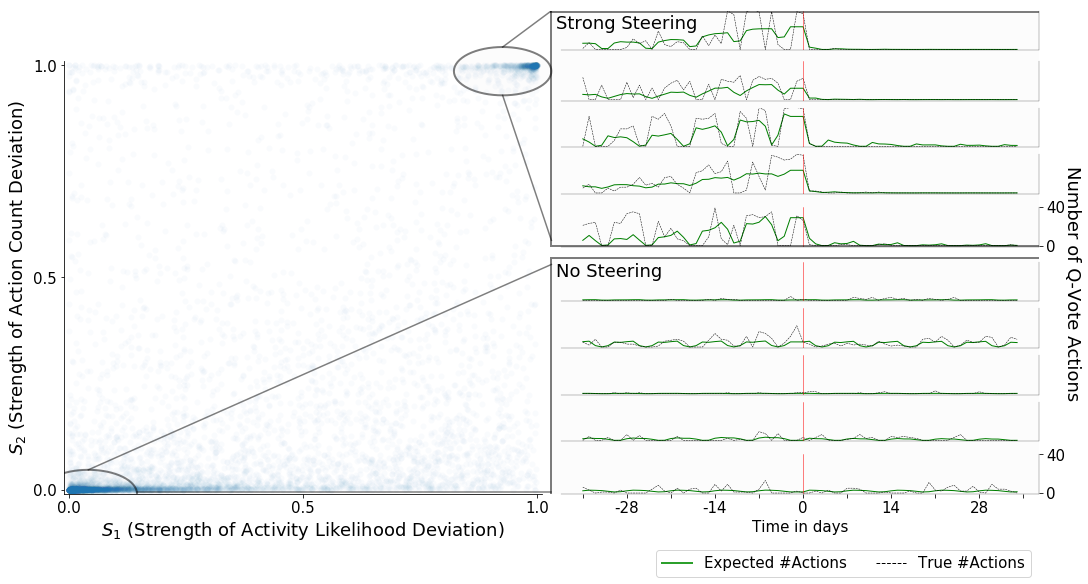

In [77]:
# plot v2
import matplotlib
# from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from descartes import PolygonPatch
import shapely
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.ops import cascaded_union

fig3 = plt.figure(figsize=(15,8), constrained_layout=True)

t1, t2, t3, t4, t5, t6 = -.1, 1, .70, 0, .025, 2


def get_polygons():
#     offset = .2
    p = [
#         Polygon([[ t1,  t3-.1],[ t1,  t2-.1],[ t4,  t6],[ t6,  t6],[ t6, t5],[ t4, t5]]),
#         Polygon([[ t1, -t3-.15], [ -.85, -t3-.15], [ -.85, -t2],[ t1,-t2],[ t4,  -t6],[ t6, -t6],[ t6,-t5],[ t4,-t5]])
        Polygon([[ t4,  t6],  [ t6,  t6],[ t6, t5],  [ t4, t5]]),
        Polygon([[ t4,  -t6], [ t6, -t6],[ t6,-t5],  [ t4,-t5]])
# #         Polygon([[-t1, -t2],[-t1, -t3],[-t4, -t6],[-t6, -t6],[-t6,-t5],[-t4,-t5]]),
# #         Polygon([[ t1, -t2],[ t1, -t3],[ t4, -t6],[ t6, -t6],[ t6,-t5],[ t4,-t5]]),
# #         Polygon([[-t1,  t2],[-t1,  t3],[-t4,  t6],[-t6,  t6],[-t6, t5],[-t4, t5]])
    ] 
    return cascaded_union(p)

def get_circle():
    p = [
        Point((t1), t3-(t3-t2)/2-.1).buffer(.1),
#         Point((-t1), t3-(t3-t2)/2).buffer(.3),
#         Point((t1), -(t3-(t3-t2)/2)).buffer(.3),
        Point(-.95, -(t3-(t3-t2)/2)-.15).buffer(.1)
    ]
    return cascaded_union(p)

def plot_line(ax, arrays, lim=[-1,40], ticks=[0,40]):
    arrays[0][5*7] = arrays[0][5*7-2]
    arrays[0][5*7-1] = arrays[0][5*7-2]
    ax.plot(arrays[0], c='green', lw=1)
    ax.plot(arrays[1], c='black', ls='--', lw=.5)
    ax.axvline(5*7, c='red', lw=.5)
    ax.set_ylim([-1,40])
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    return ax

gs = fig3.add_gridspec(11, 8)

# top_left_axes = []
# for i in range(5):
#     ax = fig3.add_subplot(gs[i, :4])
#     plot_line(ax, top_left[i])
#     top_left_axes.append(ax)
    
bottom_left_axes = []
for i in range(5):
    ax = fig3.add_subplot(gs[6+i, -4:])
    plot_line(ax, bottom_left[i])
    bottom_left_axes.append(ax)
    
top_right_axes = []
for i in range(5):
    ax = fig3.add_subplot(gs[i, -4:])
    plot_line(ax, [top_right[1],top_right[0],top_right[2],top_right[3],top_right[4]][i])
    top_right_axes.append(ax)
    
# bottom_right_axes = []
# for i in range(5):
#     ax = fig3.add_subplot(gs[6+i, -4:])
#     plot_line(ax, bottom_right[i])
#     bottom_right_axes.append(ax)
    
center_ax = fig3.add_subplot(gs[1:, :-4])

sigmoid = lambda x: np.exp(x)/(1+ np.exp(x))

center_ax.scatter(sigmoid(w1*np.array(latent_dim)), 
                  sigmoid(w2*np.array(latent_dim2)), alpha=.025, color='C0', lw=0)
# center_ax.hexbin(sigmoid(w1*np.array(latent_dim)), 
#                   sigmoid(w2*np.array(latent_dim2)),  cmap='rainbow', lw=0)
# center_ax.axvline(0, ymin=0.05, ymax=.95, c='black')
# center_ax.axhline(0, xmin=0.05, xmax=.95, c='black')
center_ax.set_xlim([-.01,1.01])
center_ax.set_ylim([-.01,1.01])

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
# center_ax.spines['left'].set_position('center')
# center_ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
center_ax.spines['right'].set_color('none')
center_ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
# center_ax.xaxis.set_ticks_position('bottom')
center_ax.yaxis.set_ticks_position('left')

tot_ax = fig3.add_subplot(gs[:,:])
tot_ax.set_axis_off()
patch2b = PolygonPatch(get_polygons(), fc='black', ec='black', lw=2, alpha=.01, zorder=2)
tot_ax.add_patch(patch2b)
patch3b = PolygonPatch(get_circle(), fc='black', ec='black', lw=2, alpha=.01, zorder=2)
tot_ax.add_patch(patch3b)

patch2b = PolygonPatch(get_polygons(), fc='None', ec='black', lw=2, alpha=.5, zorder=2)
tot_ax.add_patch(patch2b)
patch3b = PolygonPatch(get_circle(), fc="None", ec='black', lw=2, alpha=.5, zorder=2)
tot_ax.add_patch(patch3b)

tot_ax.add_line(Line2D([-.1, 0], [.85, 1], color='black', alpha=.5))
tot_ax.add_line(Line2D([-.1, 0], [.65, .05], color='black', alpha=.5))

tot_ax.add_line(Line2D([-.95, 0], [-.9, -.05], color='black', alpha=.5))
tot_ax.add_line(Line2D([-.85, 0], [-.99, -.99], color='black', alpha=.5))

tot_ax.set_xlim([-1,1])
tot_ax.set_ylim([-1,1])

all_ax =   bottom_left_axes + top_right_axes
# all_ax = [center_ax]

for j, ax in enumerate(all_ax):
    if not j%5 == 4:
        ax.axes.get_yaxis().set_visible(False)
#     ax.set_axis_off()
#     ax.set_frame_on(False)
#     ax.axes.get_yaxis().set_visible(False)
    ax.axes.set_xticks([])
    ax.yaxis.tick_right()
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
#     ax.spines['bottom'].set_position('center')
    ax.spines['left'].set_color('none')
    ax.spines['top'].set_color('none')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.25)
    
    
# # left axes
# for ax in (top_left_axes + bottom_left_axes):
#     ax.axes.get_yaxis().set_visible(False)
#     ax.axes.set_xticks([])
# #     ax.yaxis.tick_right()
#     pass 

# # right axes
# for ax in (top_right_axes + bottom_right_axes):
#     ax.axes.set_xticks([])
#     ax.yaxis.tick_right()
#     pass 

# # top axes
# for ax in (top_left_axes + top_right_axes):
#     ax.set_ylim([-1,40])
#     pass 

# # bottom axes
# for ax in (bottom_right_axes + bottom_left_axes):
#     ax.set_ylim([-1,10])
#     pass 

# add labels
# top_right_axes[-1].set_xlabel('Strong Steering', fontsize=18)
# top_right_axes[-1].set_xlabel('Strong Steering', fontsize=18)

# bottom_right_axes[-1].set_xlabel('Rate Change', fontsize=15)
# top_left_axes[-1].set_xlabel('Intensity Change', fontsize=15)
bottom_left_axes[-1].set_xlabel('Time in days', fontsize=15)
bottom_left_axes[-1].set_xticks(np.arange(0, 11*7, 7))
bottom_left_axes[-1].set_xticklabels([i if i%14==0 else "" for i in np.arange(-5*7, 6*7, 7)], fontsize=15)

# center_ax.annotate('S2', xy=(-.1, 11.1), xytext=(-1.5, 11.1), arrowprops=None, fontsize=15)
# center_ax.annotate('Number of Q-Vote Actions', xy=(1, .75), xytext=(1, .75), arrowprops=None, 
#                                            fontsize=15, rotate=90)
tot_ax.text(1.05, .3, 'Number of Q-Vote Actions', rotation=270, fontsize=18)

tot_ax.text(.01, .925, 'Strong Steering', rotation=0, fontsize=18)
tot_ax.text(.01, -.1, 'No Steering', rotation=0, fontsize=18)
tot_ax.axhline(1, xmin=.5, xmax=1, c='black', alpha=.5, lw=3)
# tot_ax.yaxis.set_label_position("right")
# tot_ax.yaxis.tick_right()
# top_right_axes[-1].set_ylabel('Number of Q-Vote Actions')

center_ax.set_xlabel('$S_1$ (Strength of Activity Likelihood Deviation)', fontsize=18)
center_ax.set_ylabel('$S_2$ (Strength of Action Count Deviation)', fontsize=18)
tk_lbls = ["%.1f"%i for i in np.arange(0,1.2,0.5)]
center_ax.set_xticks(np.arange(0,1.2,0.5))
center_ax.set_xticklabels(tk_lbls, fontsize=15)
center_ax.set_yticks(np.arange(0,1.2,0.5))
center_ax.set_yticklabels(tk_lbls, fontsize=15)

custom_lines = [Line2D([0], [0], color='C2', lw=2),
                Line2D([0], [0], color='black', ls='--', lw=1)]
plt.legend(
    custom_lines, ['Expected #Actions', 'True #Actions'],
    bbox_to_anchor=(1.0, -0.1), ncol=2, fontsize=15
)

fig3.savefig('/Users/nickhoernle/Desktop/cover_image_2.pdf', format='pdf', bbox_inches='tight')

# fig3.tight_layout()
plt.show()

# Count of Badges for Steerers vs Non-steerers

In [139]:
np.sum(s1_s2), np.sum(min_s1_min_s2)

(1458, 2894)

In [140]:
u_ids = np.array(u_ids)

In [141]:
import json
with open("{}/badge_achievements.json".format('../data'), 'r') as f:
    badge_ids = json.load(f)
    
steer_badges = []
for user in u_ids[s1_s2]:
    user_dat = badge_ids[user]
#     steer_badges.append(np.sum([len(v) for v in user_dat.values()]))
    steer_badges.append(len(user_dat.keys()))
    
no_steer_badges = []
for user in u_ids[min_s1_min_s2]:
    user_dat = badge_ids[user]
#     no_steer_badges.append(np.sum([len(v) for v in user_dat.values()]))
    no_steer_badges.append(len(user_dat.keys()))

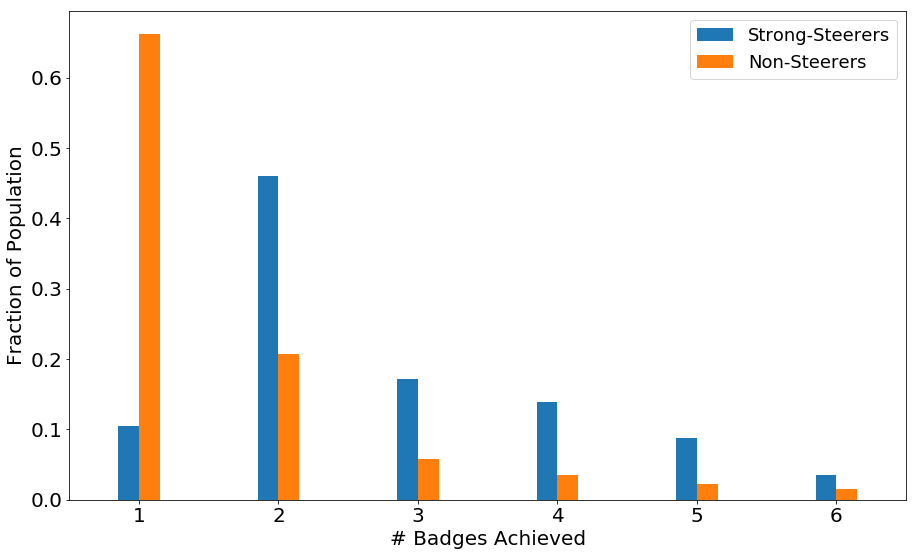

In [142]:
plt.figure(figsize=(15,9))
plt.hist([steer_badges,no_steer_badges],
         bins=np.arange(8), 
         alpha=1,
         color=['C0', 'C1'], 
         density=True, 
         rwidth=.3,
         label=['Strong-Steerers', 'Non-Steerers'])
# plt.hist(no_steer_badges, width=.3, alpha=.5, color='red', density=True, label='# badges achieved for non-steerers')
plt.xticks(np.arange(8)+.5, np.arange(8))
plt.xlim([1,7])
plt.legend(loc='best', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('# Badges Achieved', fontsize=20)
plt.ylabel('Fraction of Population', fontsize=20)

fig = plt.gcf()
fig.savefig('/Users/nickhoernle/Desktop/badge_counts.eps', format='eps', bbox_inches='tight')

# make plots thinner
plt.show()

# Calculate NLL of mean parameterised

In [97]:
x_obs=[]
for loader in [train_loader]:
    for x_in, kernel, x_out, prox, badge_ix, u_id in loader:
        x_in, kernel, x_out, prox, badge_ix = x_in.to(device),\
                                                kernel.to(device),\
                                                x_out.to(device),\
                                                prox.to(device),\
                                                badge_ix.to(device)
        
        for i in range(len(x_out)):
            x_obs += [x_out[i].detach().numpy()]
        
x_obs = np.array(x_obs)

In [98]:
x_obs.shape

(4149, 70)

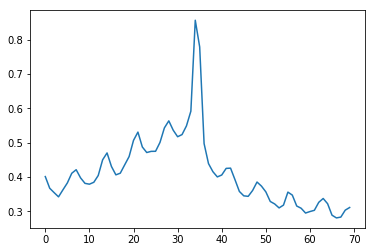

In [99]:
p = np.mean(x_obs>0, axis=0)
plt.plot(p)

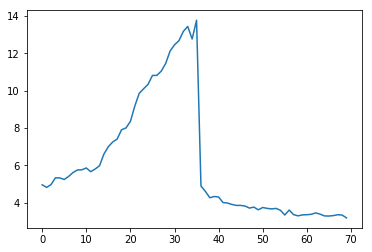

In [100]:
lambda_ = np.mean(x_obs/p, axis=0)
plt.plot(lambda_)

In [101]:
import scipy.stats as stats

In [77]:
l_likelihood=[]
reconst_loss=0

for loader in [test_loader]:
    for x_in, kernel, x_out, prox, badge_ix, u_id in loader:
        x_in, kernel, x_out, prox, badge_ix = x_in.to(device),\
                                                kernel.to(device),\
                                                x_out.to(device),\
                                                prox.to(device),\
                                                badge_ix.to(device)
        for i in range(len(x_out)):
            l_likelihood += [np.sum(np.log(p) + stats.poisson(lambda_).logpmf(x_out[i].detach().numpy()))]
            exp = p*lambda_
            reconst_loss += np.mean((exp-x_out.detach().numpy())**2)
reconst_loss/=len(test_loader.dataset)

In [78]:
np.mean(l_likelihood), reconst_loss

(-459.7056619409321, 49.2611161941033)

In [79]:
for params_ in zip(model.parameters(), model.parameters()):
    p = params_[0]

# Theoretical Prediction

In [248]:
threshold = 1000
users = []
params = [(3,3),(3,3),(3,3),(3,3),(3,3),(3,5),(3,5)]
for i in range(2000):
    
    user = []
    user_sum = 0
    day_count = 0
    dists = [np.random.beta(*params[j]) for j in range(7)]
#     dists[0] = dists[1]
#     dists[3] = dists[2]
#     dists[4] = dists[2]
#     dists[5] = dists[2]
#     dists[6] = dists[2]
    
    tot_count = 0
    
    while day_count < 35:
        
        acts = np.random.negative_binomial(1, dists[tot_count%7])
        user.append(acts)
        
        user_sum += acts
        tot_count += 1
        
        if user_sum > threshold:
            day_count += 1
            
    user = np.array(user).astype(int)
    user = user[-70:]
    users.append(user)
    
# users_2000 = users

Text(0.5, 0, 'Day from threshold')

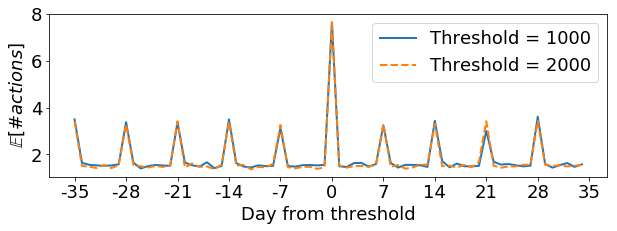

In [272]:
plt.figure(figsize=(10, 3))
plt.plot(np.mean(users, axis=0), c='C0', lw=2, label='Threshold = 1000')
plt.plot(np.mean(users_2000, axis=0), c='C1', ls='--', lw=2, label='Threshold = 2000')
plt.legend(loc='best', fontsize=18)
plt.xticks(np.arange(0,71,7), np.arange(-5*7,6*7,7), fontsize=18)
plt.yticks(np.arange(2,10,2), np.arange(2,10,2), fontsize=18)
plt.ylabel('$\mathbb{E}[ \# actions ]$', fontsize=18)
plt.xlabel('Day from threshold', fontsize=18)
# plt.axhline(1.75)

(array([ 10.,  15.,  44.,  81., 133., 181., 203., 186., 110.,  37.]),
 array([0.12712017, 0.21165153, 0.29618289, 0.38071424, 0.4652456 ,
        0.54977696, 0.63430832, 0.71883968, 0.80337104, 0.8879024 ,
        0.97243376]),
 <a list of 10 Patch objects>)

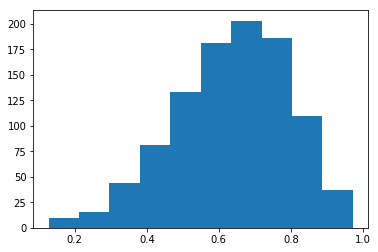

In [233]:
plt.hist(np.random.beta(5,3, size=1000))